# 6. Text Generation using our model

__Note:__ model_kaggle was trained on Kaggle, which uses another version of keras (2.6.0.), so install the correct keras version first.

In [2]:
#from pprint import pprint
import re
import numpy as np
import string
import random
from more_itertools import split_before # for splitting list into sublists
!pip install keras==2.6.0 # if model trained in kaggle is used
import tensorflow as tf
import pickle
!pip install pronouncing
import pronouncing
import nltk # for tagging words
nltk.download('averaged_perceptron_tagger') # for using default pos_tag
nltk.download('universal_tagset') # for using pos_tag with tagset = "universal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 34.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.6.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 939 kB 34.6 MB/s 
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6252 sha256=afe65abc4119b47a446738b4a1876b3391537734527635e28dc74473c433973e
  Stored in directory: /root/.cache/pip/wheels/09/e8/c0/3606d42fdbf5f3871564eb6a353591a8f5deeed013fdb

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [4]:
# Loading objects:
with open('./data/objs.pkl','rb') as f:
    c, dictionary, index_to_word, word_to_index, SEQ_LENGTH, VOCAB_SIZE, BATCH_SIZE = pickle.load(f)

In [5]:
tf.keras.__version__ # is 2.6.0 on Kaggle where the model was trained

'2.6.0'

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, LSTM, Embedding, GRU

In [7]:
# load the model
model = tf.keras.models.load_model('model_kaggle.h5')

In [8]:
# function to tokenize user input text
def tokenize(text: str):

  # turn to all lowercase to reduce vocabulary size
  text = text.lower()

  # remove punctuation but keep <> for <START>
  punctuation = "".join([punct for punct in string.punctuation if punct not in {"<", ">", "'"}])
  for punct in punctuation:
      text = text.replace(punct, ' '+punct+' ')

  # split by whitespace and newline, keep newline character
  words = re.split(r"( |\n)", text)

  # remove whitespace from list
  unwanted = {"", " "}
  words = [elem for elem in words if elem not in unwanted]

  # split list into sublists (1 list per song)
  # there should be a strict separation between songs, ie. the last words from one
  #  song should not be used to predict the first words from the next song
  words = list(split_before(words, lambda x: x == "<start>"))

  # returns nested list (1 song = 1 list)
  return(words)

In [9]:
# function to count syllables
# Stolen from: https://eayd.in/?p=232
def sylco(word) :

    word = word.lower()

    # exception_add are words that need extra syllables
    # exception_del are words that need less syllables

    exception_add = ['serious','crucial']
    exception_del = ['fortunately','unfortunately']

    co_one = ['cool','coach','coat','coal','count','coin','coarse','coup','coif','cook','coign','coiffe','coof','court']
    co_two = ['coapt','coed','coinci']

    pre_one = ['preach']

    syls = 0 #added syllable number
    disc = 0 #discarded syllable number

    #1) if letters < 3 : return 1
    if len(word) <= 3 :
        syls = 1
        return syls

    #2) if doesn't end with "ted" or "tes" or "ses" or "ied" or "ies", discard "es" and "ed" at the end.
    # if it has only 1 vowel or 1 set of consecutive vowels, discard. (like "speed", "fled" etc.)

    if word[-2:] == "es" or word[-2:] == "ed" :
        doubleAndtripple_1 = len(re.findall(r'[eaoui][eaoui]',word))
        if doubleAndtripple_1 > 1 or len(re.findall(r'[eaoui][^eaoui]',word)) > 1 :
            if word[-3:] == "ted" or word[-3:] == "tes" or word[-3:] == "ses" or word[-3:] == "ied" or word[-3:] == "ies" :
                pass
            else :
                disc+=1

    #3) discard trailing "e", except where ending is "le"  

    le_except = ['whole','mobile','pole','male','female','hale','pale','tale','sale','aisle','whale','while']

    if word[-1:] == "e" :
        if word[-2:] == "le" and word not in le_except :
            pass

        else :
            disc+=1

    #4) check if consecutive vowels exists, triplets or pairs, count them as one.

    doubleAndtripple = len(re.findall(r'[eaoui][eaoui]',word))
    tripple = len(re.findall(r'[eaoui][eaoui][eaoui]',word))
    disc+=doubleAndtripple + tripple

    #5) count remaining vowels in word.
    numVowels = len(re.findall(r'[eaoui]',word))

    #6) add one if starts with "mc"
    if word[:2] == "mc" :
        syls+=1

    #7) add one if ends with "y" but is not surrouned by vowel
    if word[-1:] == "y" and word[-2] not in "aeoui" :
        syls +=1

    #8) add one if "y" is surrounded by non-vowels and is not in the last word.

    for i,j in enumerate(word) :
        if j == "y" :
            if (i != 0) and (i != len(word)-1) :
                if word[i-1] not in "aeoui" and word[i+1] not in "aeoui" :
                    syls+=1

    #9) if starts with "tri-" or "bi-" and is followed by a vowel, add one.

    if word[:3] == "tri" and word[3] in "aeoui" :
        syls+=1

    if word[:2] == "bi" and word[2] in "aeoui" :
        syls+=1

    #10) if ends with "-ian", should be counted as two syllables, except for "-tian" and "-cian"

    if word[-3:] == "ian" : 
    #and (word[-4:] != "cian" or word[-4:] != "tian") :
        if word[-4:] == "cian" or word[-4:] == "tian" :
            pass
        else :
            syls+=1

    #11) if starts with "co-" and is followed by a vowel, check if exists in the double syllable dictionary, if not, check if in single dictionary and act accordingly.

    if word[:2] == "co" and word[2] in 'eaoui' :

        if word[:4] in co_two or word[:5] in co_two or word[:6] in co_two :
            syls+=1
        elif word[:4] in co_one or word[:5] in co_one or word[:6] in co_one :
            pass
        else :
            syls+=1

    #12) if starts with "pre-" and is followed by a vowel, check if exists in the double syllable dictionary, if not, check if in single dictionary and act accordingly.

    if word[:3] == "pre" and word[3] in 'eaoui' :
        if word[:6] in pre_one :
            pass
        else :
            syls+=1

    #13) check for "-n't" and cross match with dictionary to add syllable.

    negative = ["doesn't", "isn't", "shouldn't", "couldn't","wouldn't"]

    if word[-3:] == "n't" :
        if word in negative :
            syls+=1
        else :
            pass   

    #14) Handling the exceptional words.

    if word in exception_del :
        disc+=1

    if word in exception_add :
        syls+=1     

    # calculate the output
    return numVowels - disc + syls

In [ ]:
# expected input shape of the model
model.input_shape # batch dimension, sequence length, vocabulary size (incl. tags)

(None, 10, 25002)

<h2>Generating Text from the model</h2>

Generating text is split up into various subtasks:<br>
- *sample_word* takes the output of the model (a vector of probabilities) as an input to determine which word should follow next. This should not always be the word that has the highest probability as this would lead to "overfitting" in terms of being very similar to the training lyrics. Therefore we introduce some randomness into it.
- *generate_word* is iteratively called to use the model to predict the next word. It also handles rhyming, ie. it re-weights words that rhyme if at this position there should be a rhyme.
- *generate_chapter* is based on the idea that we don't want a coherent string of lyrics but rather "chapters" in the sense of a chorus or a verse. Based on the chapter type the model behaves differently, eg. uses different rhyming patterns for chorus vs. verses.
- *generate_song* is the function that pastes the functions above together. It takes user input and will then generate the whole song.

In [10]:
# define punctuation characters and add newline character
PUNCT = string.punctuation + "\n"

# find their indices
punct_indices = [word_to_index[i] for i in PUNCT if i in word_to_index]

# define tags that are the placeholders but should not be returned in the generated text
TAGS = ['<.>', '<ADJ>', '<ADP>', '<ADV>', '<CONJ>', '<DET>', '<NOUN>', '<NUM>', '<PRON>', '<PRT>', '<VERB>', '<X>']

# add words that should not be returned (at least for the songs presented at Lighthouse)
bad_words = ["nigga", "niggas", "motherfucker", "fuck", "fucked", "bitch", "bitches"]
bad_indices = [word_to_index[i] for i in bad_words]

In [11]:
# sample the next word based on the previous sequence
# don't always take the word with the highest probability but introduce randomness by increasing the parameter "temperature"
def sample_word(preds, temperature = 0.8, ban_punctuation = False):
  # the higher the temperature, the more random the word
  # the lower, the more conservative (might lead to copying existing lyrics)
  preds = np.asarray(preds).astype('float64')

  # newline characters should never be returned with our current approach
  preds[0][word_to_index["\n"]] = 1e-10

  # some unprofessional words should also not be returned
  preds[0][bad_indices] = 1e-10

  # should not return puncutations characters, so set their probabilty very low (but not 0 because of taking the log later)
  if ban_punctuation:
    #preds[0][word_to_index["\n"]] = 1e-10
    preds[0][punct_indices] = 1e-10

  # take logarithm of predictions and divide by temperature
  # when calculating the exponential function again, lower temperature values lead
  #  to a curve that is more on the right bottom than the linear line exp(log(pred))
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)

  # the reweighted predictions are then used as probabilities to draw from a multinomial distribution
  probas = np.random.multinomial(1, preds[0], 1)

  # the index of the highest value is then returned
  return np.argmax(probas)

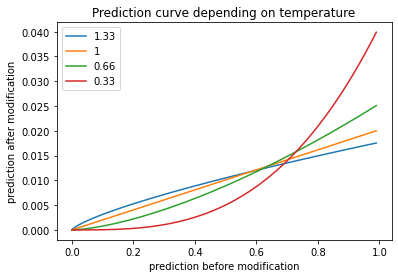

In [12]:
# visualising the behaviour of predictions depending on the temperature
import matplotlib.pyplot as plt
temperatures = [1.33, 1, 0.66, 0.33]
x = np.arange(1e-10, 1, 0.01)
for i, temp in enumerate(temperatures):
  exp_preds = np.exp(np.log(x) / temp)
  y = exp_preds / np.sum(exp_preds)
  #y = (np.exp(np.log(x) / temp)) / np.sum(np.exp(np.log(x) / temp))
  plt.plot(x, y, label = temp)
plt.legend()
#plt.grid()
plt.title('Prediction curve depending on temperature')
plt.xlabel('prediction before modification')
plt.ylabel('prediction after modification')
plt.show()

the HIGHER the temperature, the flatter the prediction curve.<br>
therefore, predictions are more equal, meaning that the possibility of choosing different indices for each repetition gets increased.<br>
consequently, for LOWER temperature, high prediction values stay high after modification and the distance to the next highest values get's bigger, meaning that the chance that the highest value (before modification) get's chosen is increased.

In [14]:
# generate the next word
def generate_word(sequence_indices, sequence_words, temperature = 0.8, rhyme_with = None, rhyming_reweight_factor = 100000, ban = False):
  # ban refers to banning punctuation characters from being generated

  # make empty matrix to fill with one-hot encoded sequence
  # first dimension is needed to make predictions with the model (batch dimension)
  X = np.zeros((1, SEQ_LENGTH, VOCAB_SIZE), dtype=bool)

  # consider relevant sequence (latest x entries, based on SEQ_LENGTH of the model)
  n_elements = len(sequence_indices)
  if n_elements < SEQ_LENGTH: # = 10 currently
    relevant = sequence_indices
  else:
    relevant = sequence_indices[n_elements - SEQ_LENGTH : n_elements + 1]

  # fill sequence into created matrix
  for i, token in enumerate(relevant):
    X[0, i, token] = 1
  
  # calculate predictions
  predictions = model.predict(X)

  if rhyme_with is not None:
    print("--------------------------------------------------------------------")
    # find words that rhyme
    print("Rhyme with: " + rhyme_with)
    rhyming_words = pronouncing.rhymes(rhyme_with)
    print("Possible rhymes: " + str(rhyming_words))
    # reweight words that rhyme
    indices_to_reweight = [word_to_index.get(key) for key in rhyming_words]
    indices_to_reweight = [i for i in indices_to_reweight if i is not None]
    print("Found in dictionary: " + str([index_to_word[i] for i in indices_to_reweight]))
    print("Top 10 predictions BEFORE reweight: " + str([index_to_word[i] for i in np.argpartition(predictions[0], -10)[-10:]]))
    predictions[:,indices_to_reweight] = predictions[:,indices_to_reweight] * rhyming_reweight_factor
    print("Top 10 predictions AFTER reweight: " + str([index_to_word[i] for i in np.argpartition(predictions[0], -10)[-10:]]))
    # should not return punctuation character, so set it's probabilty very low (but not 0 because of taking the log later)
    ban = True # used as input for sample_word
 
  # sample the next word (index of the word) 
  next_index = sample_word(predictions, temperature = temperature, ban_punctuation = ban)
  next_word = index_to_word[next_index]

  # catch if the generated word is unwanted (is a tag, or same to the one to be rhymed with)
  # don't allow two same tokens after another
  # check if the model is stuck on a specific pattern consisting of two tokens, eg. hey, hey, and would then generate another hey
  # not used currently: specifically don't allow two punctuations characters after each other
  # (next_word in PUNCT and sequence_words[-1] in PUNCT)
  t = temperature
  r = rhyme_with
  b = ban
  #repeated_pattern = (sequence_words[-2:] == sequence_words[-4:-2]) and (next_word == sequence_words[-2])
  while (next_word in TAGS or next_word == r or next_word == sequence_words[-1] or ((sequence_words[-2:] == sequence_words[-4:-2]) and (next_word == sequence_words[-2]))):
   print("Re-do...")
   t = t*1.5
   next_index, next_word = generate_word(sequence_indices, sequence_words, temperature = t, rhyme_with = r, ban = b)

  return next_index, next_word

In [15]:
def generate_chapter(sequence_indices, sequence_words, temperature = 0.8, n_lines = 4, chapter_type = "chorus", verse_pattern = "ABABAB"):

    # Initialize with something:
    MIN_SENTENCE_LENGTH_SYLLABLES = 10
    MAX_TOKENS = 15

    # if we generate chorus starting from user input, we have a reference point for rhyming
    if chapter_type == "chorus":
      # last word from second-to-last line (excluding punctuations)
      # but: how to handle stuff in brackets? (yeah, yeah, yeah) etc.
      RHYME_CURRENT = [word for word in list(split_before(sequence_words, lambda x: x == "\n"))[-3] if not word in PUNCT][-1]
      # last word from last line (excluding punctuations)
      RHYME_NEXT = [word for word in list(split_before(sequence_words, lambda x: x == "\n"))[-2] if not word in PUNCT][-1]
    
    # if we generate the verse, the first two lines should be "free", then the third rhymes with the first and so on
    if chapter_type == "verse":
      RHYME_CURRENT = None
      RHYME_NEXT = None
      SKIP_1_LINE = True # if verse_pattern = "-A-A-A", skip first line, then act like "A-A-A-"

    # generate fixed number of lines
    for sentence_no in range(n_lines):
      current_sentence = []
      # initialize syllables count
      curr_sent_syls = 0
      LAST_WORD_IN_SENTENCE = False

      # every line has a maximum number of words
      for word_no_in_sentence in range(MAX_TOKENS):
        # print("Line %d - Word %d out of MAX %d - Syllable %d out of MAX %d" %(sentence_no, word_no_in_sentence, MAX_TOKENS, curr_sent_syls, MIN_SENTENCE_LENGTH_SYLLABLES))
        # if there are already more syllables than our minimum, stop the line
        if curr_sent_syls >= MIN_SENTENCE_LENGTH_SYLLABLES or word_no_in_sentence == MAX_TOKENS - 1:
          #print("Stopping this line")
          LAST_WORD_IN_SENTENCE = True
          rhyme_with_now = RHYME_CURRENT

          # ban all punctuations at the end of the sentence
          # Note: newline character is banned anyways!
          ban_all_punctuations = True
        else:
          rhyme_with_now = None
          ban_all_punctuations = False

        next_index, next_word = generate_word(sequence_indices, sequence_words, temperature = temperature, rhyme_with = rhyme_with_now, ban = ban_all_punctuations)
        # note: handling unwanted tags is implemented in generate_word

        if rhyme_with_now is not None:
          print("Picked: " + next_word)

        sequence_indices.append(next_index)
        sequence_words.append(next_word)
        current_sentence.append(next_word)
        curr_sent_syls = sylco(' '.join(current_sentence))

        if LAST_WORD_IN_SENTENCE:
          # if there's open parenthesis, add closing one
          if "(" in current_sentence and ")" not in current_sentence:
            sequence_indices.append(word_to_index[")"])
            sequence_words.append(")")

          # end line with newline character
          sequence_indices.append(word_to_index["\n"])
          sequence_words.append("\n")

          if (chapter_type == "chorus") or (verse_pattern == "ABABAB"):
            # ABABAB rhyme pattern
            RHYME_CURRENT = RHYME_NEXT
            RHYME_NEXT = next_word

          # implement different rhyme pattern for verse 
          if chapter_type == "verse":
            if verse_pattern == "AAAAAA":
              # AAAAAA (rhyme every line with each other)
              RHYME_NEXT = next_word
              RHYME_CURRENT = RHYME_NEXT

            if verse_pattern == "AABBCC":
              # AABBCC
              if RHYME_CURRENT is None:
                RHYME_CURRENT = next_word
              
              else:
                RHYME_CURRENT = None

            if verse_pattern == "A_A_A_":
              # A_A_A_
              if RHYME_NEXT is None:
                RHYME_NEXT = next_word
                RHYME_CURRENT = None
              
              else:
                RHYME_CURRENT = RHYME_NEXT
                RHYME_NEXT = None
            
            if verse_pattern == "_A_A_A":
              # _A_A_A
              if SKIP_1_LINE:
                SKIP_1_LINE = False
              else:
                if RHYME_NEXT is None:
                  RHYME_NEXT = next_word
                  RHYME_CURRENT = None
                
                else:
                  RHYME_CURRENT = RHYME_NEXT
                  RHYME_NEXT = None

          break

    whole_chorus_indices = sequence_indices.copy()
    whole_chorus_words = sequence_words.copy()

    return whole_chorus_indices, whole_chorus_words

In [16]:
# generate song by sampling new words
def generate_song(text_input = None, temperature = 0.8, chorus_length = 4, verse_length = 6, verse_pattern = "ABABAB"):
    
    if text_input is not None:
      text_input = tokenize(text_input)[0]

      # if first character is newline, delete it
      if text_input[0] == "\n":
        text_input = text_input[1:]

      # if last character is not newline, add newline
      if text_input[-1] != "\n":
        text_input.append("\n")

      # change to numerical representation
      start_index = []
      for word in text_input:
        try: 
          index = word_to_index[word]
        except KeyError:
          # if word is not in vocabulary, replace it with it's tag (eg. noun, verb, etc.)
          tag = nltk.pos_tag([word], tagset = "universal")[0][1]
          word = "<" + tag + ">"
          index = word_to_index[word]
        start_index.append(index)

    else:
      # select random word from vocabulary
      start_index = list(np.random.randint(low = 0, high = VOCAB_SIZE, size = 1))

    # create two sequences, one for the generated indices and one for the generated words  
    seq_generated = []
    seq_generated.extend(start_index)

    seq_words = []
    seq_words.extend([index_to_word[index] for index in seq_generated])

    # instead of randomly generating a sequence word by word, create a structure of lines connected to each other
    # generate chorus from user input and then 2 verses

    # count number of lines of user input
    n_lines_user_input = sum([word == "\n" for word in seq_words])

    # check if there are at least 2 lines to know where to rhyme
    if n_lines_user_input < 2:
      raise ValueError("User input not long enough, should be at least 2 lines")

    # if number of user input lines >= inputted chorus length, treat user input as chorus and don't generate more
    if n_lines_user_input >= chorus_length:
      print("Treat user input as whole chorus")
      chorus_indices, chorus_words = seq_generated.copy(), seq_words.copy()
      
    # else, generate rest of chorus
    else:    
      chorus_indices, chorus_words = generate_chapter(seq_generated, seq_words, n_lines = chorus_length - n_lines_user_input, chapter_type = "chorus")
      # when generating the chorus, seq_words and seq_generated are automatically appended
      # save chorus_words nevertheless, as we will copy it later
    
    seq_generated.append(word_to_index["\n"])
    seq_words.append("\n")

    # generate first verse
    generate_chapter(seq_generated, seq_words, n_lines = verse_length, chapter_type = "verse", verse_pattern = verse_pattern)
    seq_generated.append(word_to_index["\n"])
    seq_words.append("\n")
    # save index to mask chorus with user input later
    chorus_2_start = len(seq_words)

    # copy chorus
    seq_generated.extend(chorus_indices)
    seq_words.extend(chorus_words)
    seq_generated.append(word_to_index["\n"])
    seq_words.append("\n")

    # generate second verse
    generate_chapter(seq_generated, seq_words, n_lines = verse_length, chapter_type = "verse", verse_pattern = verse_pattern)

    # replace tags that come from the user input by the correct words from the user input   
    if text_input is not None:
      seq_words[0:len(text_input)] = text_input
      seq_words[chorus_2_start:chorus_2_start+len(text_input)] = text_input

    # add newline character at start again
    seq_words = ["\n"] + seq_words

    # paste generated words to one string
    text = " ".join(seq_words)

    # clean the text with custom function
    text = clean_text(text)

    return text


In [13]:
# function cleans the text by removing unnecessary whitespace
def clean_text(text: str):
    # delete extra space from punctuation
    for i in PUNCT:
      #print(i)
      if i == "(":
        text = re.sub("\( ", i, text)
      elif i == ")":
        text = re.sub(" \)", i, text)
      elif i == "\\":
        text = re.sub(r" \\", r"\\", text)
      elif i == "\n":
        text = re.sub(r" \n", r"\n", text)
      else:
        text = re.sub(" \\" + i, i, text)
    
    return text

# Try out the model!

In [ ]:
input = """
Straight outta Vienna, everybody wants to be a member
We are Lumos, the best, yeah that's us
"""

In [17]:
input = """
Shining from our lighthouse, call us illuminated
Straight outta Vienna, Lumos is our name
"""

In [25]:
# choose rhyming pattern for verse from "ABABAB", "AAAAAA", "AABBCC", "A_A_A_", "_A_A_A" (default "ABABAB")
song = generate_song(text_input = input, temperature = 0.8, chorus_length = 4, verse_length = 6, verse_pattern = "AABBCC")

Picked: complicated
Picked: game
Picked: me
Picked: night
Re-do...
Picked: part
Picked: love
Picked: right
Picked: can


In [26]:
print(song)


 shining from our lighthouse, call us illuminated
 straight outta vienna, lumos is our name
 but if i could not leave here is complicated
 i've been looking for you, so looking game

 we're all in a love feelin' like we
 come on and roll with me, baby, under me
 embrace the world just to make it right
 love some time to love this night
 listen to the heart that's made of my heart
 and i still got to keep you still wrote and part

 shining from our lighthouse, call us illuminated
 straight outta vienna, lumos is our name
 but if i could not leave here is complicated
 i've been looking for you, so looking game

 i just feel like i'm dying inside, above
 i don't want to be your lover, but i love
 i wanna be your lover, yeah, in the candlelight tonight
 and we can just go home in the club right
 i just brought it some more (one more dollars)
 but only i go (chasing new), who else can



__Notes__:<br>
model_kaggle was trained with vocabulary of 24990 real words and 10,315,059 sequences of length 10. The Network had Total params: 16,092,330.